In [1]:
import time
import nltk.tokenize as nt
import json
import torch
import copy
import datasetgenerator as dsg
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from torch.utils.data import (TensorDataset, DataLoader, RandomSampler,
                              SequentialSampler)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import device
import torch.optim as optim




In [2]:
AUTHOR1 = "coutinho-dataset"
AUTHOR2 = "denser-dataset"
PATH_TO_RAW_DATA = "data/raw/"
PATH_TO_PARSED_DATA = "data/parsed/"

ds_gen = dsg.DS_Gen()

In [3]:
len_data = ds_gen.get_data_length(dsg.DS_Gen.DENSER)
print(len_data)

1614


In [4]:
dictAuthors = dict()

In [5]:
def map_to_number(dict, word):
    if(word in dict.keys()):
        return dict.get(word)
    else:
        next_value = len(dict.keys())
        dict.update({word: next_value})
        return next_value

In [6]:
dictAuthors.update({"padding": 0})
map_to_number(dictAuthors, "unknown")

1

In [7]:
def tokenize_words_in_paragraph(paragraph, dict):
    tensor = []
    parsed_paragraph = nt.word_tokenize(paragraph)
    for word in parsed_paragraph:
        token = map_to_number(dict, word)
        tensor.append(token)
    return tensor

In [8]:
def get_paragraph_size_list(paragraph_set):
    paragraph_sizes = []
    for paragraph in paragraph_set:
        paragraph_size = len(paragraph)
        paragraph_sizes.append(paragraph_size)
    return paragraph_sizes

In [9]:
train_dataset_1, test_dataset_1 = ds_gen.get_dataset_from_author(dsg.DS_Gen.COUTINHO, 0.8, 1605)
train_dataset_2, test_dataset_2 = ds_gen.get_dataset_from_author(dsg.DS_Gen.DENSER, 0.8, 1605)

In [10]:
train_dt_1_sizes = get_paragraph_size_list(train_dataset_1)
train_dt_2_sizes = get_paragraph_size_list(train_dataset_2)
test_dt_1_sizes = get_paragraph_size_list(test_dataset_1)
test_dt_2_sizes = get_paragraph_size_list(test_dataset_2)

In [11]:
train_dataset_raw_both = copy.deepcopy(train_dataset_1)
train_dataset_raw_both.extend(train_dataset_2)

In [12]:
test_dataset_raw_both = copy.deepcopy(test_dataset_1)
test_dataset_raw_both.extend(test_dataset_2)

In [13]:

train_labels = [0]*len(train_dataset_1)
train_labels_2 = [1]*len(train_dataset_2)

train_labels.extend(train_labels_2)

In [14]:
test_labels = [0]*len(test_dataset_1)
test_labels_2 = [1]*len(test_dataset_2)

test_labels.extend(test_labels_2)

In [15]:
all_data = copy.deepcopy(train_dt_1_sizes)
all_data.extend(train_dt_2_sizes)
all_data.extend(test_dt_1_sizes)
all_data.extend(test_dt_2_sizes)

520.6500000000001


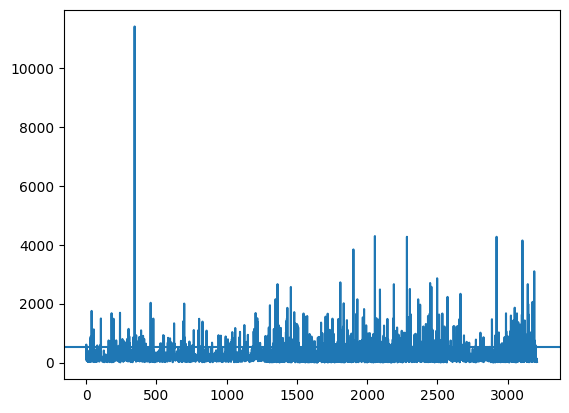

In [16]:
plt.plot(all_data)
percetile = np.percentile(all_data, 85)
print(percetile)
plt.axhline(y=percetile)

In [17]:
train_dt_2_sizes = get_paragraph_size_list(train_dataset_2)

In [18]:
def normalize_data(data, rule):
    while (len(data) < rule):
        data.append(0)

    if(len(data) > rule):
        data = data[0:rule]
    return data 

In [19]:
def tokenize_paragraph_set(paragraph_set):
    tokenized_paragraph_set= []
    for paragraph in paragraph_set:
        lowered_paragraph = paragraph.lower()
        tokenized_paragraph = tokenize_words_in_paragraph(lowered_paragraph, dictAuthors)
        tokenized_paragraph = normalize_data(tokenized_paragraph, 520)
        tokenized_paragraph_set.append(tokenized_paragraph)
    return tokenized_paragraph_set

In [20]:
tokenized_set1 = tokenize_paragraph_set(train_dataset_1)

In [21]:
tokenized_set2 = tokenize_paragraph_set(train_dataset_2)

In [22]:
train_dataset_both_tokenized = copy.deepcopy(tokenized_set1)
train_dataset_both_tokenized.extend(tokenized_set2)

In [23]:
tokenized_test1 = tokenize_paragraph_set(test_dataset_1)

In [24]:
tokenized_test2 = tokenize_paragraph_set(test_dataset_2)

In [25]:
test_dataset_both_tokenized = copy.deepcopy(tokenized_test1)
test_dataset_both_tokenized.extend(tokenized_test2)

In [26]:
with open('authorsDict.json', 'w', encoding='utf-8') as f:
    json.dump(dictAuthors, f, ensure_ascii=False, indent=4)
f.close

<function TextIOWrapper.close()>

In [27]:
def load_pretrained_vectors(word2idx, fname):
    
    print("Loading pretrained vectors...")
    fin = open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())

    print(n)
    print(d)

    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), d))
    embeddings[word2idx['padding']] = np.zeros((d,))

    count = 0
    for line in fin:
        #print(line)
        tokens = line.rstrip().split(' ')
        word = tokens[0]
        if word in word2idx:
            count += 1
            embeddings[word2idx[word]] = np.array(tokens[1:], dtype=np.float32)

    print(f"There are {count} / {len(word2idx)} pretrained vectors found.")

    return embeddings

In [28]:
# Run the following command lines on the repo's root folder to download the embedding file and uncompress it.
# curl https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.pt.300.vec.gz --output cc.pt.300.vec.gz
# gzip -dk cc.pt.300.vec.gz
embeddings = load_pretrained_vectors(dictAuthors, "cc.pt.300.vec")
embeddings = torch.tensor(embeddings)

Loading pretrained vectors...
2000000
300
There are 20130 / 21344 pretrained vectors found.


In [29]:
def data_loader(train_inputs, test_inputs, train_labels, test_labels,
                batch_size=50):
   
    train_inputs, test_inputs, train_labels, test_labels =\
    tuple(torch.tensor(data) for data in
          [train_inputs, test_inputs, train_labels, test_labels])

    batch_size = 50

    train_data = TensorDataset(train_inputs, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    test_data = TensorDataset(test_inputs, test_labels)
    test_sampler = SequentialSampler(test_data)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

    return train_dataloader, test_dataloader

In [30]:

train_dataloader, test_dataloader = data_loader(train_dataset_both_tokenized, test_dataset_both_tokenized, train_labels, test_labels, batch_size=50)

In [31]:
filter_sizes = [2, 3, 4]
num_filters = [2, 2, 2]

In [32]:
class CNN_NLP(nn.Module):
    def __init__(self,
                 pretrained_embedding=None,
                 freeze_embedding=False,
                 vocab_size=None,
                 embed_dim=300,
                 filter_sizes=[3, 4, 5],
                 num_filters=[100, 100, 100],
                 num_classes=2,
                 dropout=0.5):
        
        super(CNN_NLP, self).__init__()
        
        if pretrained_embedding is not None:
            self.vocab_size, self.embed_dim = pretrained_embedding.shape
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding,
                                                          freeze=freeze_embedding)
        else:
            self.embed_dim = embed_dim
            self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                          embedding_dim=self.embed_dim,
                                          padding_idx=0,
                                          max_norm=5.0)
       
        self.conv1d_list = nn.ModuleList([
            nn.Conv1d(in_channels=self.embed_dim,
                      out_channels=num_filters[i],
                      kernel_size=filter_sizes[i])
            for i in range(len(filter_sizes))
        ])
       
        self.fc = nn.Linear(np.sum(num_filters), num_classes)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input_ids):
        
        x_embed = self.embedding(input_ids)

        x_reshaped = x_embed.permute(0, 2, 1)

        x_conv_list = [F.relu(conv1d(x_reshaped)) for conv1d in self.conv1d_list]

        x_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2])
            for x_conv in x_conv_list]
        
        x_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list],
                         dim=1)
        
        logits = self.fc(self.dropout(x_fc))

        return logits

In [33]:
dvc = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

def initialize_model(pretrained_embedding=None,
                    freeze_embedding=False,
                    vocab_size=None,
                    embed_dim=300,
                    filter_sizes=[3, 4, 5],
                    num_filters=[100, 100, 100],
                    num_classes=2,
                    dropout=0.5,
                    learning_rate=0.01):

    assert (len(filter_sizes) == len(num_filters)), "filter_sizes and num_filters need to be of the same length."

    cnn_model = CNN_NLP(pretrained_embedding=pretrained_embedding,
                        freeze_embedding=freeze_embedding,
                        vocab_size=vocab_size,
                        embed_dim=embed_dim,
                        filter_sizes=filter_sizes,
                        num_filters=num_filters,
                        num_classes=2,
                        dropout=0.5)

    cnn_model.to(dvc)
    cnn_model.double()

    optimizer = optim.Adadelta(cnn_model.parameters(), lr=learning_rate, rho=0.95)

    # optimizer = optim.Adam(cnn_model.parameters(),lr=learning_rate, eps=1e-06)
    return cnn_model, optimizer

In [34]:
loss_fn = nn.CrossEntropyLoss()

In [35]:
def set_seed(seed_value=42):

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

In [36]:
def evaluate(model, test_dataloader):
    model.eval()
    evaluation_start_time = time.time()
    test_accuracy = []
    test_loss = []
    for batch in test_dataloader:
        b_input_ids, b_labels = tuple(t.to(dvc) for t in batch)

        with torch.no_grad():
            logits = model(b_input_ids)

        loss = loss_fn(logits, b_labels)
        test_loss.append(loss.item())

        preds = torch.argmax(logits, dim=1).flatten()

        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        test_accuracy.append(accuracy)
        
    test_loss = np.mean(test_loss)
    test_accuracy = np.mean(test_accuracy)

    return test_loss, test_accuracy

In [37]:
def train(model, optimizer, train_dataloader, test_dataloader=None, epochs=10):

    best_accuracy = 0
    training_start_time = time.time()
    test_acc_hist=[]
    test_loss_hist=[]
    time_elapsed_hist=[]
    best_acc_hist=[]


    print("Start training...\n")
    print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Test Loss':^10} | {'Test Acc':^9} | {'Elapsed':^9}")
    print("-"*60)

    for epoch_i in range(epochs):
     
        t0_epoch = time.time()
        total_loss = 0

        model.train()

        for step, batch in enumerate(train_dataloader):
           
            b_input_ids, b_labels = tuple(t.to(dvc) for t in batch)
            model.zero_grad()
            logits = model(b_input_ids)
            loss = loss_fn(logits, b_labels)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

        avg_train_loss = total_loss / len(train_dataloader)

        if test_dataloader is not None:
            test_loss, test_accuracy = evaluate(model, test_dataloader)
            if test_accuracy > best_accuracy:
                best_accuracy = test_accuracy
                best_acc_hist.append(best_accuracy)
            time_elapsed = time.time() - t0_epoch
            print(f"{epoch_i + 1:^7} | {avg_train_loss:^12.6f} | {test_loss:^10.6f} | {test_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            
        test_acc_hist.append(test_accuracy)
        test_loss_hist.append(test_loss)
        time_elapsed_hist.append(time_elapsed)

    print("\n")
    print(optimizer)
    print(f"Training complete! Best accuracy: {best_accuracy:.2f}%.")
    print('Training finished, took {:.2f}s'.format(time.time() - training_start_time))

    figure, axis = plt.subplots(2, 2)

    axis[0, 0].plot(test_acc_hist) 
    axis[0, 0].set_title("Historico de acurácia no teste") 

    axis[0, 1].plot(test_loss_hist) 
    axis[0, 1].set_title("Historico de perda no teste") 

    axis[1, 0].plot(time_elapsed_hist) 
    axis[1, 0].set_title("Historico de tempo")  
  
    axis[1, 1].plot(best_acc_hist) 
    axis[1, 1].set_title("Historico de melhora na acurácia") 

    plt.show() 


Start training...

 Epoch  |  Train Loss  | Test Loss  | Test Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.674838   |  0.643557  |   65.55   |   40.81  
   2    |   0.621027   |  0.591324  |   68.79   |   40.82  
   3    |   0.578777   |  0.570433  |   70.89   |   37.48  
   4    |   0.542300   |  0.542717  |   72.45   |   38.81  


Adadelta (
Parameter Group 0
    differentiable: False
    eps: 1e-06
    foreach: None
    lr: 0.25
    maximize: False
    rho: 0.95
    weight_decay: 0
)
Training complete! Best accuracy: 72.45%.
Training finished, took 157.91s


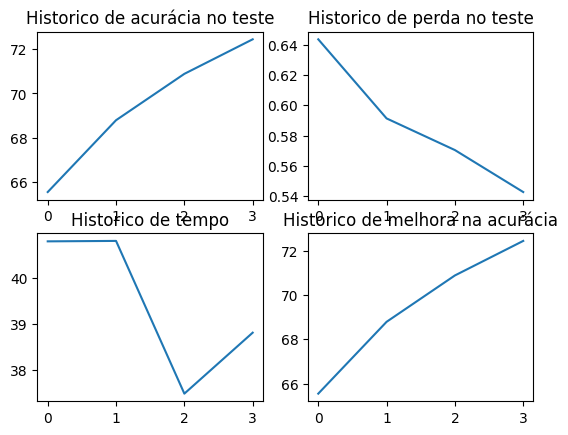

In [38]:
set_seed(42)
cnn_non_static, optimizer = initialize_model(pretrained_embedding=embeddings,
                                            freeze_embedding=False,
                                            learning_rate=0.25,
                                            dropout=0.5)
train(cnn_non_static, optimizer, train_dataloader, test_dataloader, epochs=4)

In [39]:
def tokenize_words_in_paragraph_for_predict(paragraph, dict):
    tensor = []
    dict_lenght= len(dict)
    parsed_paragraph = nt.word_tokenize(paragraph)
    for word in parsed_paragraph:
        token = map_to_number(dict, word)
        if token > dict_lenght-2:
            token = map_to_number(dict, "unknown")
        tensor.append(token)
    print(tensor) 
    return tensor

In [52]:
def predict(text, model=cnn_non_static.to("cpu"), max_len=520):

    tokens = tokenize_words_in_paragraph_for_predict(text.lower(), dictAuthors)
    padded_tokens = tokens + [0] * (max_len - len(tokens))

    input_id = torch.tensor(padded_tokens).unsqueeze(dim=0)
    logits = model.forward(input_id)

    probs = F.softmax(logits, dim=1).squeeze(dim=0)

    if probs[1] > 0.5:
        print(f"Esse parágrafo tem {probs[1] * 100:.2f}% de chance de ser Denser.")
    else:
        chance = 1 -probs[1]
        print(f"Esse parágrafo tem {chance * 100:.2f}% de chance de ser Coutinho.")


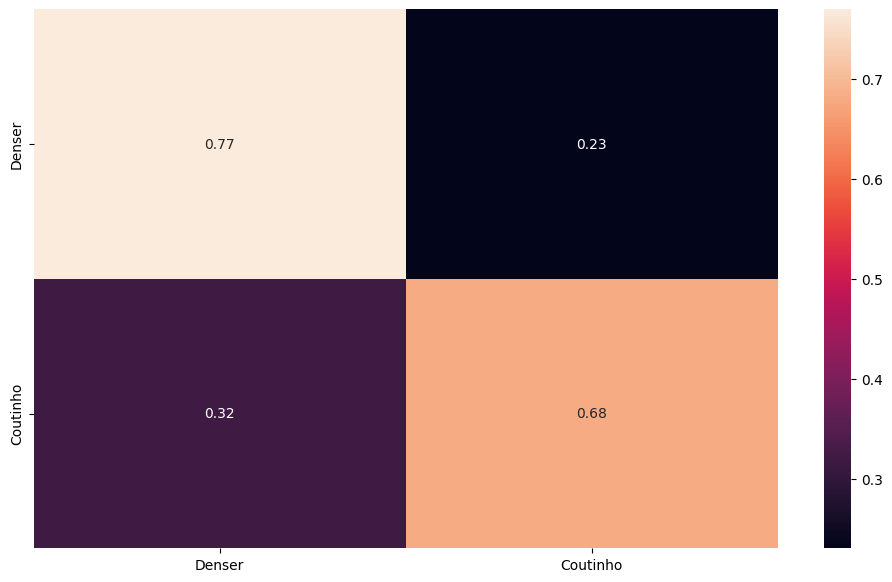

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_dataloader:
        output = cnn_non_static(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('Denser', 'Coutinho')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [42]:
torch.save(cnn_non_static.state_dict(), "cnnns.pth")
print("Saved PyTorch Model State to cnnns.pth")

Saved PyTorch Model State to cnnns.pth


In [43]:
model = cnn_non_static.to(dvc)
model = cnn_non_static.double()
model.load_state_dict(torch.load("cnnns.pth"))

<All keys matched successfully>

In [44]:
from torchviz import make_dot

input_ids = torch.tensor([[   65,   459,  1496,    52,  2832,    25,   459,  1496,   654,    52,
          6528, 10169,   248, 10170,    73, 10171,    17, 10172,   185,  9928,
            73,   436,   229,    75, 10173, 10174,    17,  9517,    17, 10175,
           450,   477,   153,  1087,    17,   531,    43,   440,     6,  1588,
           268,   120,   687,    52,   176,  3182,   450,    70,  4129, 10176,
            54,  6038,  1412, 10177,     6,   120,   126, 10178,   457,    17,
            60,   457,     6,    88, 10170,    73, 10171, 10179,    10, 10180,
         10181, 10182,    43,  2517,  1115,  3469,  6195,   355, 10183,   436,
            17, 10184,    17,  1115,  5111,    17,   160,  1899,   459,   496,
           256,   153,  5283,    58,     6, 10185,   120, 10186,    17,    43,
          1140, 10177,     6,   126, 10178,    75,  2806,    52,  2286,    17,
           647,     8,   429, 10187,    80,   126,   120,  9736,    17,     8,
           132,     9,    70, 10188,    15, 10189,    17,   817, 10190,    17,
          2438, 10191,    17,  2438, 10191,    17,     8,  2823,    52,  6428,
           266,  3287,    54,  6546,    17,   429,  2232,   219,  1261,     6,
           459,  4806,    54,  2197,    11,    17,     6,    34,  1917,  2131,
            17,    34,   614,   270, 10192,    17, 10193,    17,    34,  2092,
         10194,   185,   817,  1419,    17,     8,    34,     9,     6,   126,
         10195,  2339,    17,     8,    34,  2092, 10196,    17,   459,  1611,
           219,    52,   120,  1676,  8884,  2377,     6,  1356,   268,  8828,
           219,    52,   132,  2377,     6,  5996,    52,    34,   755,    17,
          2695,    15, 10197,    43,     6,   607,  2197, 10198,    17,   929,
           126,  1412,    34,     7,    43, 10199,  2887,    54,    43,  8601,
         10200,  4590,   215,    39,   403, 10201,   375,   669,    73,  4410,
          3480,  2351,  8601,   188,     6,     9,    70,  1705,    75,    39,
         10202,   978,    75,    39, 10203,   745,  9607,    64,   780,   978,
          4332, 10204,    10, 10205,    52,  3199,  1412,  8601,   188,   340,
          2721,    17,   340, 10206,   346,    17,   340,  6844,  4075,    17,
         10207,    15, 10208,   547,   185,  8386, 10209,   305,   372,     6,
            34,     7,    54,   496,    34,   345, 10210,    75,  2806,    52,
          2286,    17,    15,  1141,     6,   176,   468,  1873,    80,   496,
          3263,    39,  6114,    15,  8417,    54,   437,    58,    71,    15,
           124,    17,    43,  1255,  2363,    22,  1736, 10211,   961,  2643,
            52,  1009,    17, 10184,    17,  1009,   429,   487,   340,  1117,
            17, 10204,    17, 10212,    17,    65,     8,   266,   513,    15,
         10212,  9593, 10213, 10214,   536, 10215,    75,  1891,  2145,  6668,
            52,  7263,    52, 10216,    52, 10217,   250, 10218,   277,   315,
           232,   147,     6,     8, 10219,    88,  1281, 10215,  2527,    52,
         10220,    52,   340, 10221, 10222,    17,  2894,    80,    10,   838,
          1115,  8601, 10177,     7,  3220,    19, 10223,    17,   667,    17,
          6655,  9808,    15,  3518,    73,   403,     6,     8,   256,  2305,
           647,   459,   910,    64, 10183,   105,    52,    15, 10224,    17,
            73,   403,     6,     8,  2196, 10225,    52,  6655,    64,   412,
           105,    17,    80,   126,   459,   120,    34,   354,   161,   153,
          7770,    58,  8601,  9401,    17,   513,   403,     6,  2092, 10226,
            54,  9061,    17,   358,    43,     6,     8,   433,   322, 10227,
            43,    59,    52,   120,   126,  1676,    80,    70,   204,    17,
            65,   459,   619,    31,    15, 10224,    52, 10228,    52,   327,
            64,   148,    17,  1443,     6,     8,   120,   226,  1047,    43,
         10229,    17,    10,  1265,    52,    43,  1065,    54, 10205,    17,
           571,   459, 10230,    10,   644,    17, 10231,   153,    71,    15,
             8,     6,   120,  5070,   340,  1220,    17,   961,   274,    17,
           147, 10205,    17,  8952,    54,    43,  2605,    25,    80,   457,
            25,    80,   461,    25,    80,   410,   232,    17,   323,  7269,
            25,  4154,   459, 10232,    52,   429, 10233,    52,   433,   525,
            17,     8,  3836,    43,  5609,    17,   172,   817,    17,  1443,
             6,   459,    34, 10234,    34, 10235,   270,   560,    17,  1025,
            88, 10170,    73, 10171,     6, 10236,    43,   440,   153,  1087,
            17,  1846,   477,    15,  1986,    17,    80,   126,    34,   126,
         10237,    54,   131,  8286,    52,   525,   131,  3910,    17,   176,
           561,   284,    43, 10177, 10238,    54,    45,    17,    15,  2136,
             6, 10239,    43,  2158, 10240,   707,   457,   215,    31,  6063,
            54,    13,   232,    17,   459,    64,   105,    58,   440,    25,
           525,    17, 10184,    17,   649,  2353,    17,   452,    52,  3346,
            17, 10241,    17,    34,  3248,    17,   600,    17,  5858,    25,
            65,    88,  2353,   628,    80,  2141, 10242,   215, 10243,    60,
            56,   323,    43,   337,   147,     6, 10244,    64, 10183,  1390,
            25,  5314,    17,  5314,    17,   319,  1479,   340,    56,    17,
          5314,    17,  5314,    25,    52,    48,    17,     8,    34, 10245,
           270,    17,    34,     9,  7960,    17,  5414,   319,  1217,   436,
            17,     8,    34,     9,  8622,    52,   459,    17,  4402,    17,
            52,    48,    17,     8,    34,     9, 10246,    17,     8,  1443,
             9, 10247,    17,    52,   459,    17,  8728,    17,  1096,  8728,
            17,   126,    34,     8,  8958,    17,   176,  1030,    17,   375,
             6,    34,  1030,   303,    64,   412,  1390,    17,    52,    48,
            17,  9455,    17,    34,   457,   305,   232,    17,    52,   459,
            17,    65,  1535,     6,   817,  1065,   132,   395,  6063,    54,
            13,   232,    25,    31,    17,  1375,    11,    25,    52,    48,
            17,     8,    34,     9,   167,   466,    64,    87,    17,  5149,
            19,    34,    17,    34,   652, 10248,    17,     7,    29,    25,
            52,  1496,  4034,    17,    88,  1254, 10249,    17,   160,    34,
           883,    17,   160,    34,  3182,    17,    34,  1375,    17,    34,
           904,    17,   160,   817,  1065,    34,   395,  6063,    54,  1961,
           183,    17,   817,  1065,    10,  7314, 10250,    52,   650,  2559,
            73,   761,   428,  1034,    54,    43,  4276,  9669,    17, 10251,
            52,   176,  7432,   315, 10252,    15,  7858,    52,  6348,    64,
           412,   105,    25]])

model = cnn_non_static
y = model(input_ids)

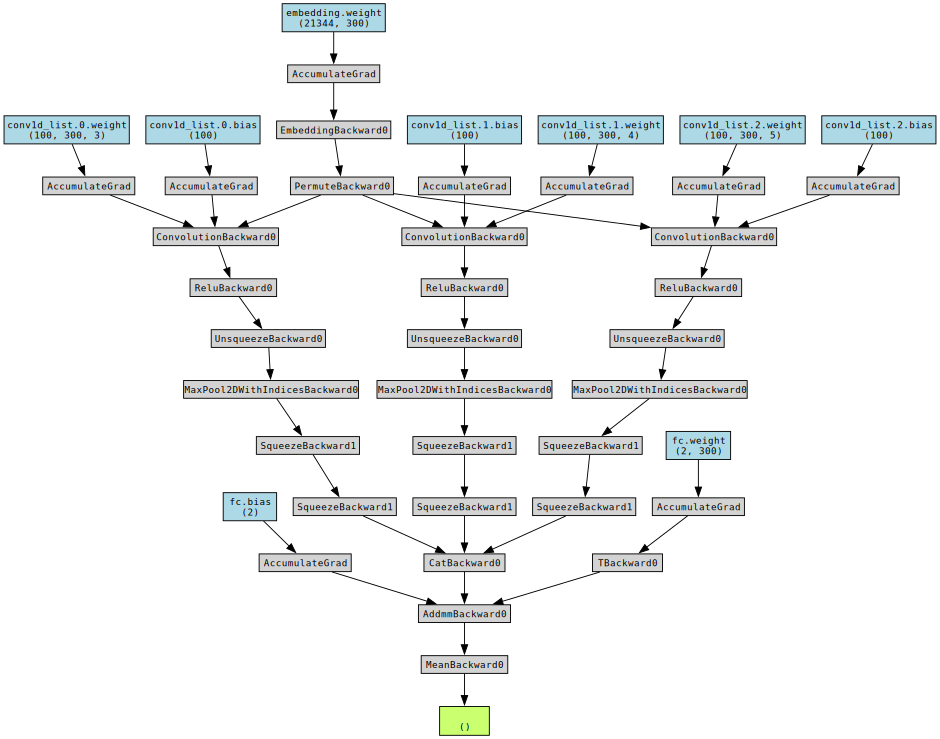

In [45]:
make_dot(y.mean(), params=dict(model.named_parameters()))

In [53]:
predict("Mas eu fui e voltei. Eu fui ontem e seriam 23h58 nos relógios da Paulista, 23h55 no farol da Casa Branca com Peixoto Gomide, porra, deviam estar andando ao contrário, contando o tempo que perdi ou já passou e então devo estar um bocado atrasada para desmanchar esse cirquinho que já se armou antes, muito antes que os relógios da Paulista começassem a contagem regressiva apontando o sentido desse passeio noturno à tua casa, Marcos, desse desvio, porque sou eu quem vai ao encontro do que praticamente já rodou, o tal cirquinho que se armou com unhas e dentes, embora você me recebesse como se já esperasse, você também tem um faro de perdigueiro, meu chapa, I know, I know, você comendo e  falando sem pausa para respirar, me deixar falar aquilo que eu vim para te dizer, que não somos nós, não há nada conosco, ok, não precisa embarcar no meu sonho, Você não tem que se arrebentar junto, você não precisa sofrer, eu tentando falar e já sentindo piedade daquilo que falava ou tentava falar e também daquilo que comia e não ouvia, repetindo de orelhada o que alguém te orelhou, ora se esse não é o gancho perfeito para o teu melodrama espanhol: uma mulher ansiosa por volta da meia-noite passando nesse teu apartamento que tem um vaso com uma arvorezinha seca com uma bandeirinha vermelha plantada na terra seca escrito Bem-vindo a Parati e observando esse teu apartamento tão pequeno, tão 21° andar, tão bloco C, caixinha de fósforos pairando no oceano cleptomaníaco dessa Cidade que não é para quem não pode conquistá-la com unhas e dentes, de maneira que então fica aí como quem comprou uma vitrine de doces para ficar do lado de fora, o nariz contra as luzes refletidas lá embaixo e isto, Marcos, isto me deixa tão triste, bem-vindo, welcome, mas você sem essa de welcome contudo botando filhodaputamente uns cds com aquelas músicas tristes e úmidas e burras e relembrando (reminds) aquela noite em que você botou os mesmos cds úmidos e burros e tão Philip Glass, percebe como a armação desse teu cirquinho é maluca? Roda, gira, sofrendo antecipadamente de saudades da mulher que você vai mandar embora eu esteja na tua frente e de touca, da mulher que você ama desesperadamente e sofrendo na minha frente, como se eu já não estivesse mais ao alcance do teu abraço, essa mulher que precisa beber para trepar, foi o que você disse subitamente desviando o rosto e já se sentindo como um vômito, mas eu ainda estava de touca e inocente e parada na sua, só que você já tinha dado o pira, a alma e o coração para Parati, enquanto eu tirava a roupa, deitava ao lado de você que já dormia tão distante, lá longe, em Parati, virado para o canto. Como antes. Como sempre. Como toda noite, até amanhecer. Daí eu levantei e me vesti e disse sim, você fez o possível, amor meu, só que eu não programei não engendrei nada disso, foram os relógios da Paulista que marcavam o tempo ao contrário, estavam andando de costas, como se não se importassem para onde iam e sim onde estiveram, então encontrei aqui o cirquinho armado para amanhã, de forma que flagrei o destino 24 horas antes: estava marcado para esta noite, eu na frente do tempo. Sim, Marcos, muitos problemas, meus e teus, individualmente, não nossos, claro, claríssimo. Mas os problemas são como velhos aquecedores: funcionam muito bem até o dia em que explodem na tua cara. Tique-taque, tique-taque, tudo ia tão bem, tique-taque, tique-taque. E ele, você não arruma nada, não tem estrutura, joga tudo pela casa, você não tem modos e eu, calada, e ele, você não tem grana, você só tem pose, e eu, enumere, vamos enumere, se não você cai, então diz, por que não diz logo na minha cara, e ele, misterioso, não antes dessa noite, e eu, mas acontece que meu coração também está marcado para esta noite. Estava, quero dizer. E ele, você não tem outra coisa na cabeça, garota? Não, não tenho saco, é isso. E fui descendo, os olhos mareados, porque não posso, porque não devo, não quero, não preciso, porque meu coração não está marcado para hora nenhuma, meu coração a ti pertence e às nove da manhã fiz sinal para o Vila Madalena, subi e então ri aquela muralha de corpos e bancos na minha frente.")

[270, 254, 165, 7, 4553, 20, 254, 165, 5030, 7, 1013, 20708, 533, 16183, 4, 11255, 9, 20709, 14, 13165, 4, 263, 1090, 16, 20710, 20711, 9, 10064, 9, 13946, 148, 4420, 158, 2925, 9, 7289, 30, 179, 34, 5421, 209, 201, 3478, 7, 361, 8630, 148, 24, 2809, 10032, 29, 8432, 443, 16665, 34, 201, 63, 20712, 410, 9, 333, 410, 34, 2, 16183, 4, 11255, 20713, 65, 20714, 20715, 11484, 30, 2393, 4102, 5061, 4681, 609, 1397, 263, 9, 7801, 9, 4102, 1953, 9, 86, 452, 254, 68, 12, 158, 1604, 99, 34, 12959, 201, 20716, 9, 30, 5481, 16665, 34, 63, 20712, 16, 1128, 7, 3824, 9, 825, 267, 161, 20717, 110, 63, 201, 7604, 9, 267, 70, 661, 24, 10909, 67, 20718, 9, 230, 12402, 9, 3828, 11974, 9, 3828, 11974, 9, 267, 6391, 7, 1568, 10, 6165, 29, 7152, 9, 161, 1541, 189, 1300, 34, 254, 3576, 29, 1865, 770, 9, 34, 104, 2623, 782, 9, 104, 332, 107, 8349, 9, 13853, 9, 104, 3677, 7140, 14, 230, 853, 9, 267, 104, 661, 34, 63, 11766, 595, 9, 267, 104, 3677, 2690, 9, 254, 841, 189, 7, 201, 2566, 4124, 1528, 34, 1155, 209,

In [54]:
predict("Não era o vocabulário habitual do seu pai. A palavra caso soou estranha, na varanda daquela casa. Como uma fala de teatro. Alguma coisa ensaiada, dita num momento previsto.")

[104, 90, 30, 1784, 1785, 99, 40, 830, 20, 65, 784, 444, 1786, 1787, 9, 194, 440, 388, 263, 20, 110, 17, 114, 67, 1788, 20, 654, 324, 1789, 9, 1055, 237, 309, 1790, 20]
Esse parágrafo tem 85.63% de chance de ser Coutinho.


In [55]:
predict("Meu nome é habitual e como uma fala estranha abajur paralelepipedo") #frase inventada

[230, 2372, 112, 1785, 7, 110, 17, 114, 1787, 7112, 1]
Esse parágrafo tem 61.07% de chance de ser Coutinho.


In [56]:
predict("Ou cruzes.")

[209, 11803, 20]
Esse parágrafo tem 54.28% de chance de ser Denser.


In [50]:
embeddings.shape

torch.Size([21344, 300])